Initializing Earth Engine API...
Preparing data...
Computing data...
GeoTIFF saved as ..\data\processed\X.tif
Preparing labels...
Computing labels...
GeoTIFF saved as ..\data\processed\y.tif


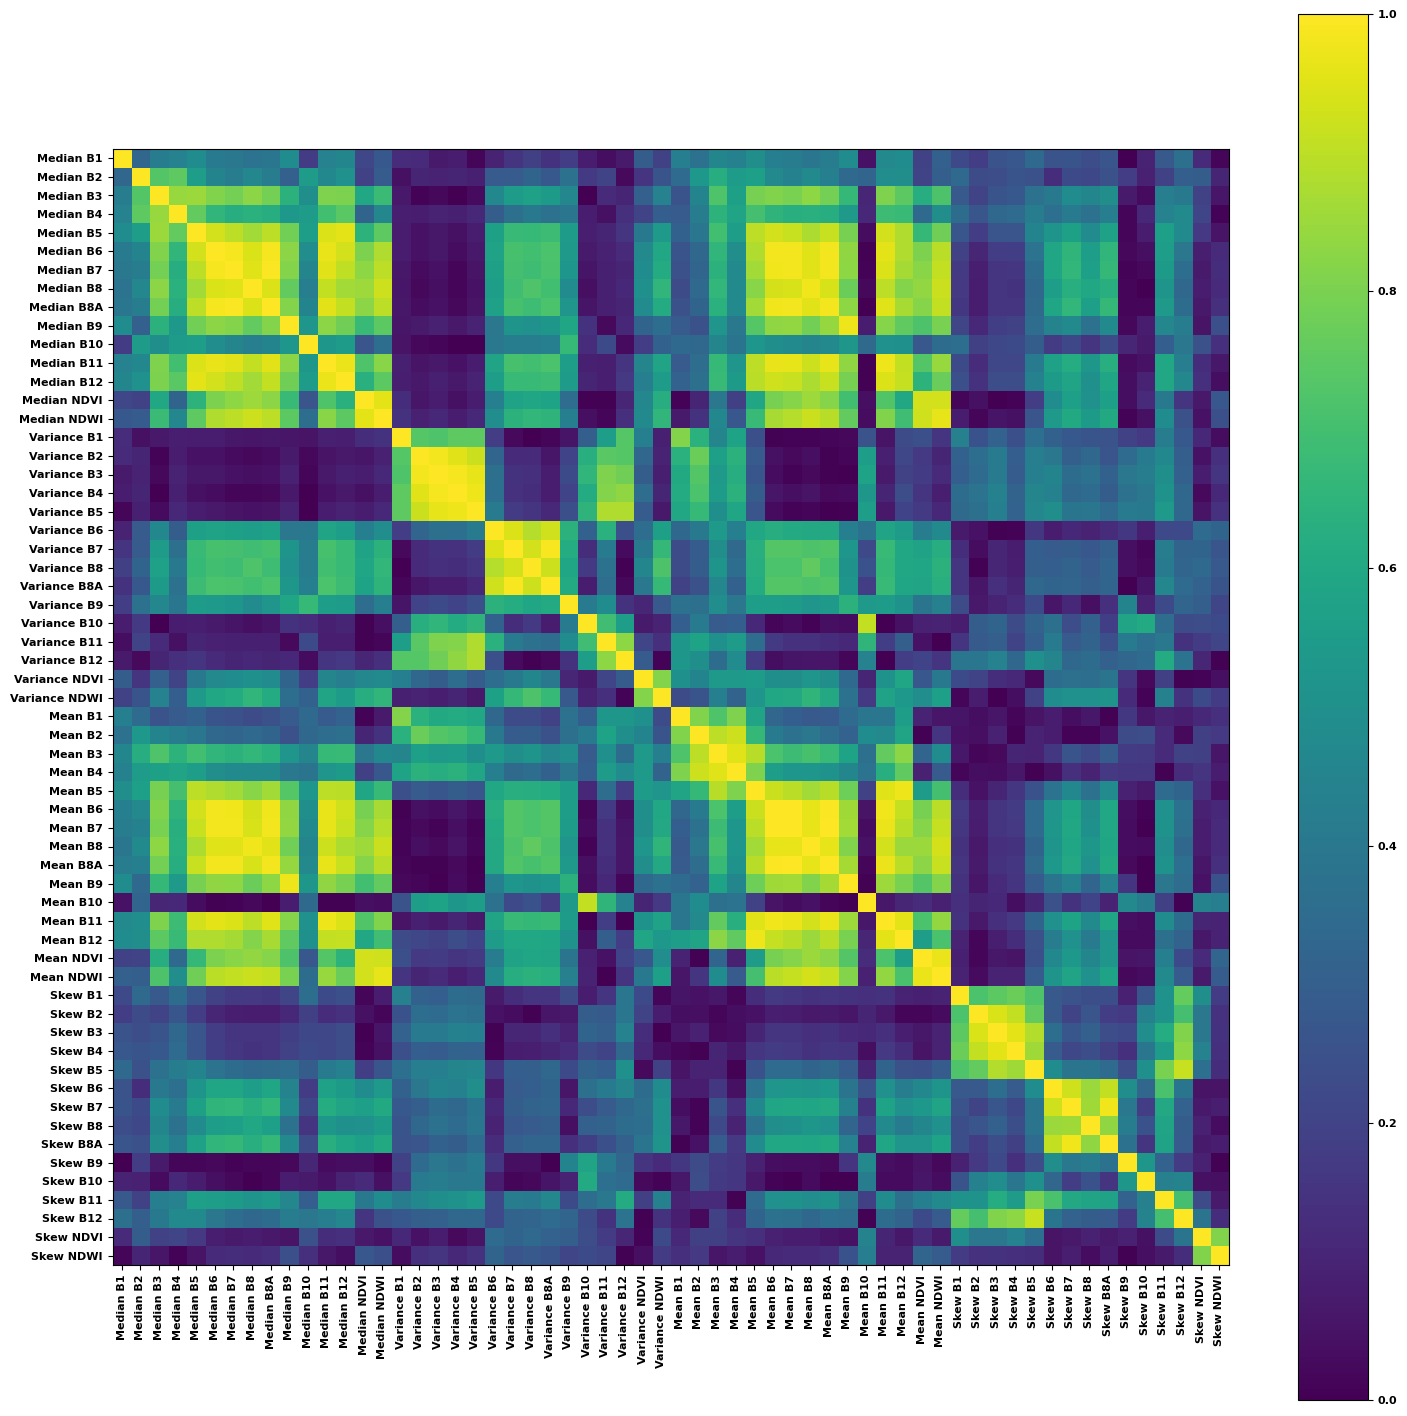

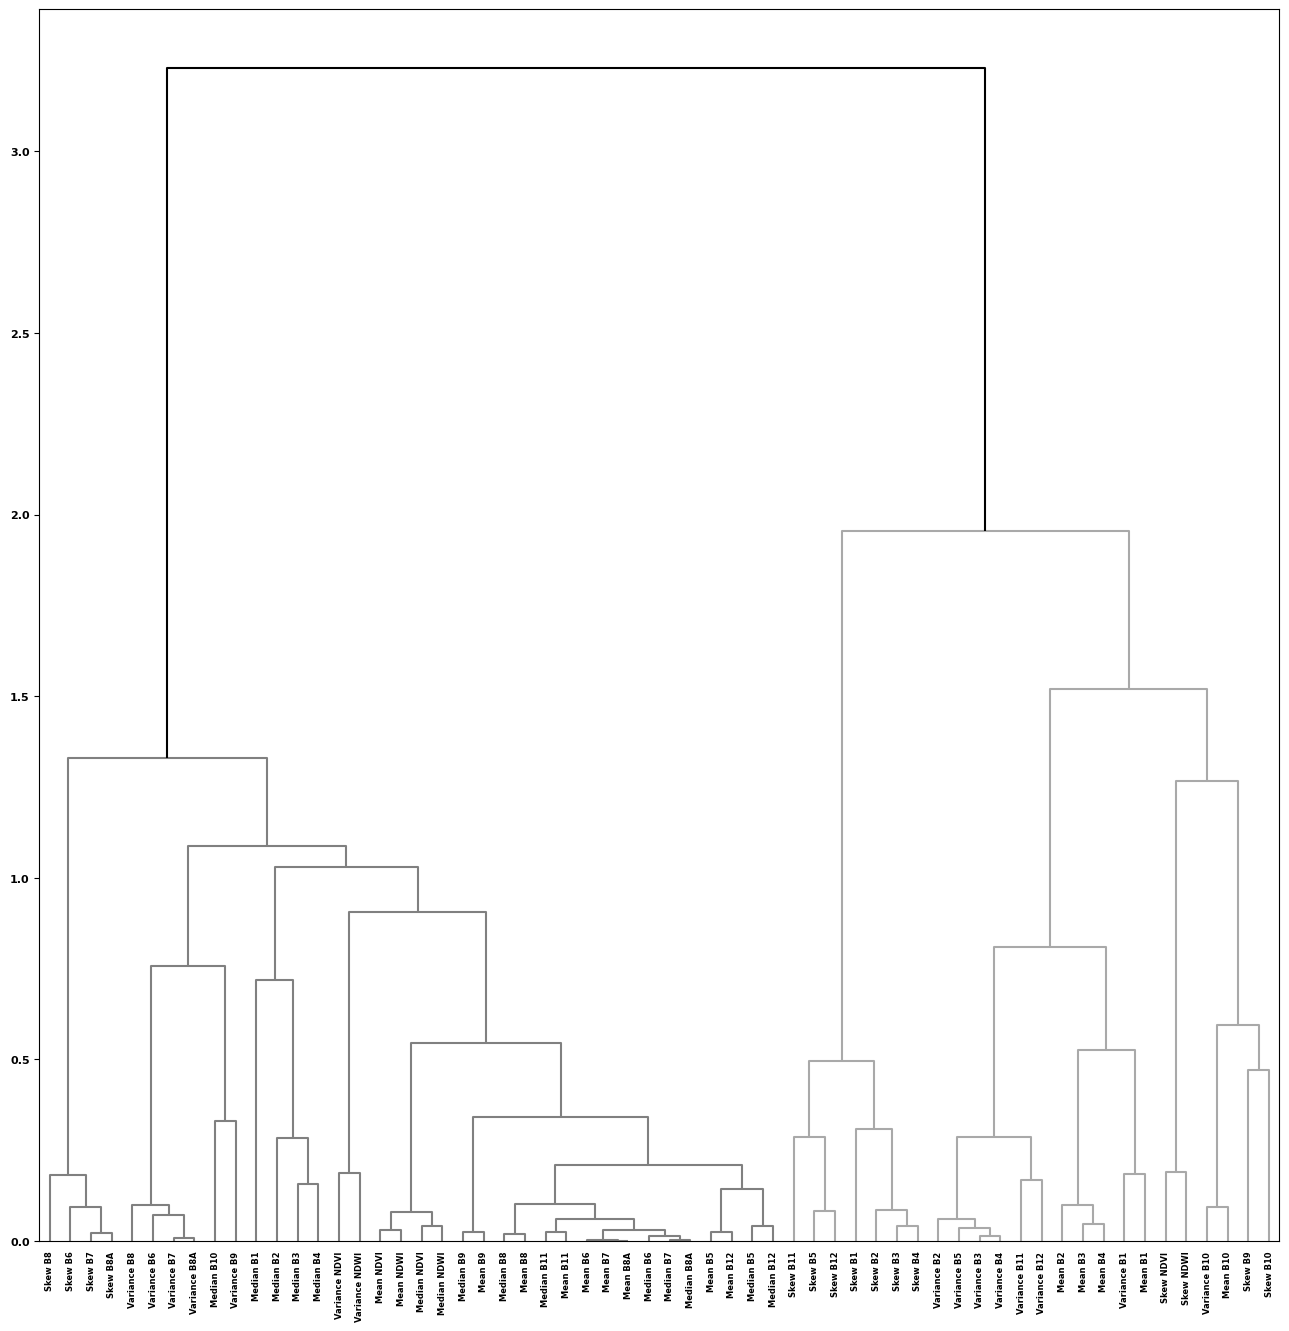

In [1]:
from src.data import sentinel_composite
from src.features import load_X_and_band_names, load_y, drop_nan, get_similarity_matrix, show_similarity_matrix, show_dendrogram
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use("./signature.mplstyle")

timewindow = ("2015-07-01", "2016-06-30")
plot = pd.read_csv("../data/processed/plot.csv")
temporal_reducers = ["min", "max", "median", "variance", "mean", "skew"]
indices = ["NDVI", "NDWI"]

X_path, y_path = sentinel_composite(
    timewindow,
    plot,
    temporal_reducers=temporal_reducers,
    indices=indices,
)

# Load data
X_path = "../data/processed/X.tif"
y_path = "../data/processed/y.tif"
X, band_names = load_X_and_band_names(X_path)
y = load_y(y_path)

# Drop NaN, split data
X, y = drop_nan(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)  # stratified is not really possible, unless every band is binned...

# Preprocess for non-tree models
standard_scaler = StandardScaler().fit(X_train)
X_train = standard_scaler.transform(X_train)
X_test = standard_scaler.transform(X_test)

# Correlation/shared information based dim red
similarity = get_similarity_matrix(X, band_names, "pearson")
sm_ax = show_similarity_matrix(similarity)
ddg_ax = show_dendrogram(similarity)

# dimred="mutual_info", threshold=0.1
# most_similar()  # https://scikit-learn.org/stable/auto_examples/inspection/plot_permutation_importance_multicollinear.html
# plot_pairplot() # Pairplot of most similar features

# # Least new information based dim red
# least_new_information()

In [2]:
# Train models
from skelm import ELMRegressor
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor
from sklearn.metrics import (make_scorer, max_error, mean_squared_error,
                             median_absolute_error, r2_score)
from scipy.stats import randint, uniform, loguniform
from xgboost import XGBRegressor
from src.models import hyperparam_search

# Define the models and hyperparameter search space with distributions: expon, gamma, uniform, loguniform or randint
search_space = {
    ELMRegressor(): {
        "alpha": loguniform(1e-8, 1e5),
        "include_original_features": [True, False],
        "n_neurons": loguniform(1, 100-1),
        "ufunc": ["tanh", "sigm", "relu", "lin"],
        "density": uniform(0.01, 0.99),
    },
    XGBRegressor(): {
        "n_estimators": randint(10, 100-10),
        "max_depth": randint(1, 20),
        "learning_rate": uniform(0.01, 0.5),
        "gamma": uniform(0, 0.5),
        "min_child_weight": randint(1, 11),
    },
    RandomForestRegressor(): {
        "n_estimators": randint(1, 100-1),
        "max_depth": randint(1, 20),
        "max_features": randint(1, 11),
        "min_samples_split": randint(2, 11),
        "min_samples_leaf": randint(1, 11),
        "bootstrap": [True, False],
        "criterion": ["squared_error", "absolute_error", "poisson", "friedman_mse"],
    },
    ExtraTreesRegressor(): {
        "n_estimators": randint(1, 100-1),
        "min_impurity_decrease": loguniform(1e-5, 0.5),
        "criterion": ["squared_error", "absolute_error"],
    },
}

# Define the scorers and refit (scorer for best model selection)
scoring = {"max_error": make_scorer(max_error,
                                    greater_is_better=False),
           "median_absolute_error": make_scorer(median_absolute_error,
                                                greater_is_better=False),
           "mean_squared_error": make_scorer(mean_squared_error,
                                             greater_is_better=False),
           "coefficient of determination": make_scorer(r2_score,
                                   greater_is_better=False),}
refit = "mean_squared_error"

search_results = hyperparam_search(
    X_train,
    y_train,
    search_space,
    scoring,
    refit,
    kfold_from_endmembers=True,
    kfold_n_splits=5,
    kfold_n_iter=10,
    random_state=0,
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits


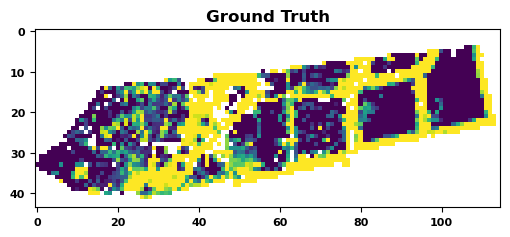

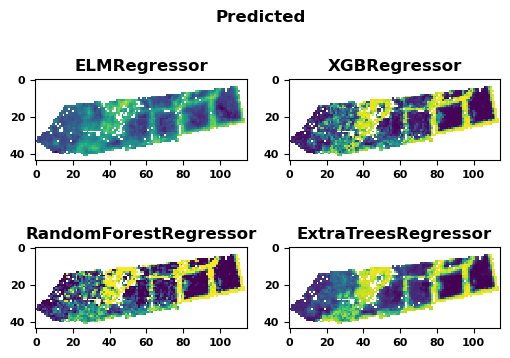

,max_error,median_absolute_error,mean_squared_error,root_mean_squared_error
ELMRegressor,0.729319,0.157146,0.076107,0.275874
XGBRegressor,0.812981,0.070721,0.041263,0.203133
RandomForestRegressor,0.784729,0.015013,0.034292,0.185180
ExtraTreesRegressor,0.709524,-0.000000,0.062762,0.250523


In [3]:
from src.models import best_scores, cv_predict

orig_plot, pred_plots = cv_predict(search_results, X_path, y_path, kfold_from_endmembers=True, random_state=0)

scores = best_scores(search_results, scoring)
scores["root_mean_squared_error"] = scores["mean_squared_error"]**0.5
scores

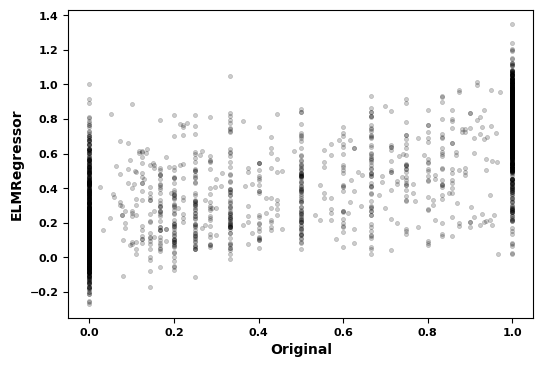

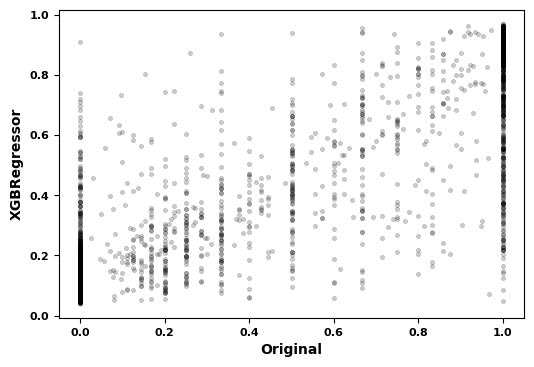

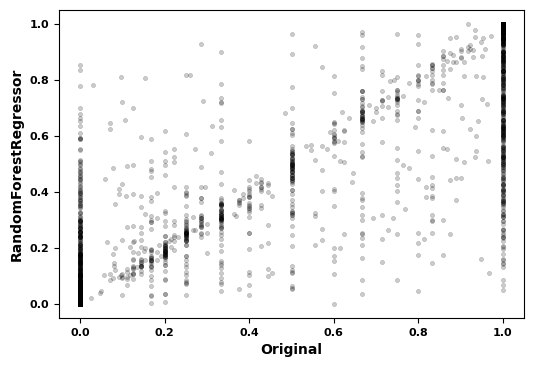

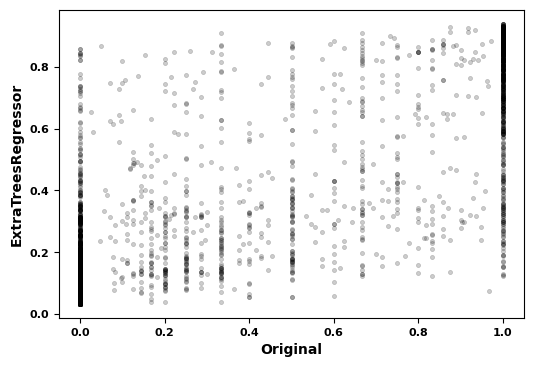

In [4]:
# Plot original and predicted values, one plot per prediction
for pred_plot, results in zip(pred_plots, search_results):
    x = orig_plot.flatten()
    y = pred_plot.flatten()
    plt.plot(x, y, ".", alpha=0.1)
    plt.xlabel("Original")
    plt.ylabel(results.best_estimator_.__class__.__name__)
    plt.show()

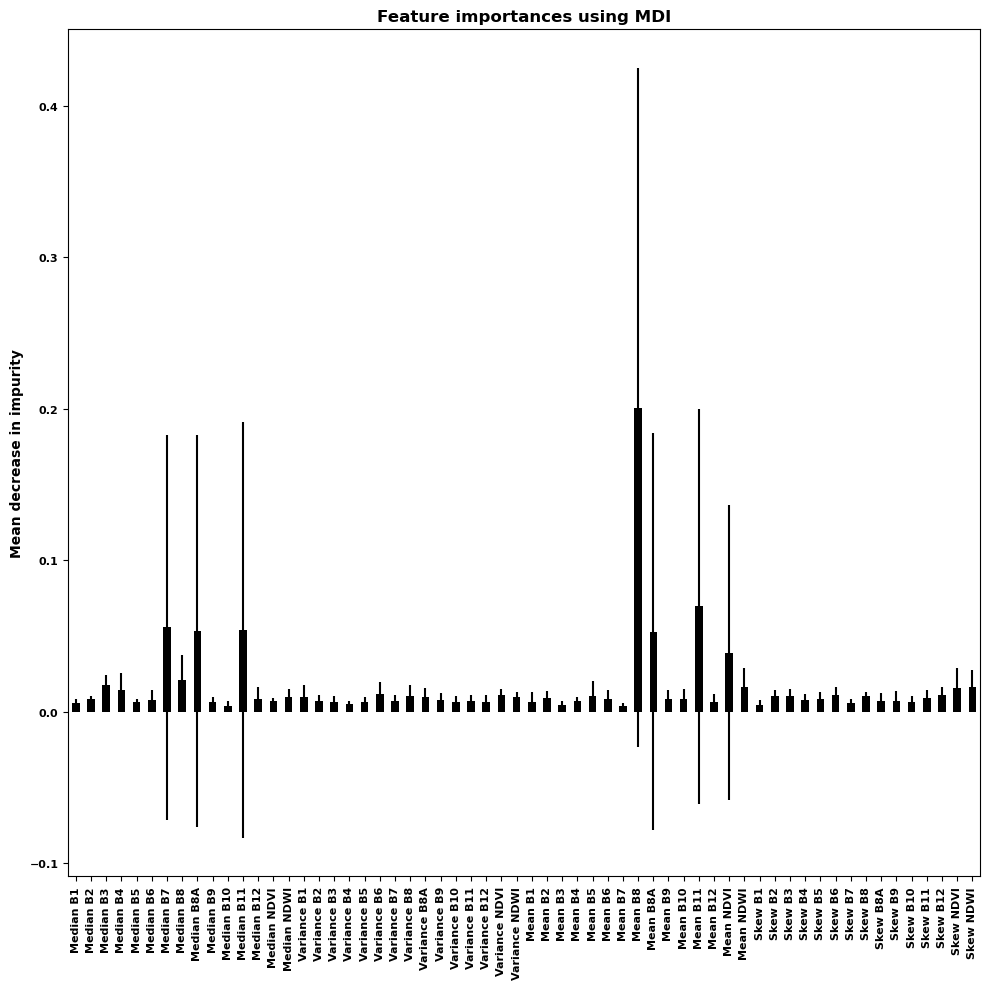

In [5]:
# Impurity based feature importance (bad if high cardinality features with many unique values are present)
import time

import numpy as np

forest = search_results[2].best_estimator_
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

import pandas as pd

forest_importances = pd.Series(importances, index=band_names)

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

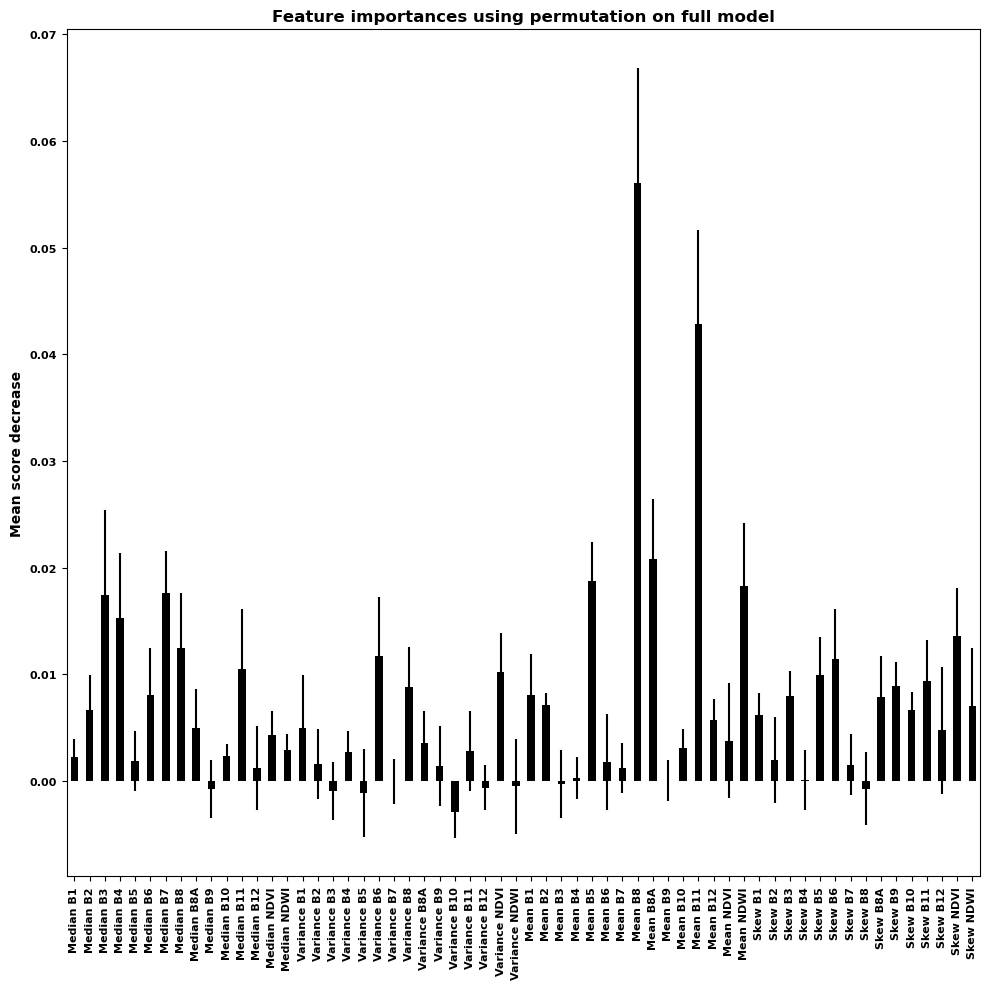

In [6]:
# Permutation importance
from sklearn.inspection import permutation_importance

result = permutation_importance(
    search_results[2].best_estimator_, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)

forest_importances = pd.Series(result.importances_mean, index=band_names)

fig, ax = plt.subplots(figsize=(10, 10))
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean score decrease")
fig.tight_layout()
plt.show()

# Temporary Stuff

In [ ]:
import numpy as np

def visualize_badly(search_results, search_space, scoring):
    # Set colors for plotting
    colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]

    # Plot the results for each parameter of each model
    for model_results, (model, param_distributions) in zip(search_results, search_space.items()):
        results = model_results.cv_results_
        for parameter in param_distributions.keys():
            # Skip if parameter is not convertible to float
            try:
                X_axis = np.array(results[f"param_{parameter}"].data, dtype=float)
            except ValueError:
                continue

            # Setup plot
            plt.figure(figsize=(13, 13))
            ax = plt.subplot()
            ax.set_xlabel(parameter)
            ax.set_ylabel("score")
            ax.set_ylim(0, 1)

            # Sort results by parameter value
            sort_idx = np.argsort(X_axis)
            X_axis = X_axis[sort_idx]
            results = {key: np.array(value)[sort_idx] for key, value in results.items()}

            # Plot the different metrics
            for (metric_name, scorer), color in zip(scoring.items(), colors):
                for sample, style in (("train", "--"), ("test", "-")):
                    sample_score_mean = results[f"mean_{sample}_{metric_name}"] * scorer._sign
                    sample_score_std = results[f"std_{sample}_{metric_name}"]
                    ax.fill_between(
                        X_axis,
                        sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == "test" else 0,
                        color=color,
                    )
                    ax.plot(
                        X_axis,
                        sample_score_mean,
                        style,
                        color=color,
                        label=f"{metric_name} ({sample})",
                    )

                # Find best score
                best_index = np.nonzero(results[f"rank_test_{metric_name}"] == 1)[0][0]
                best_score = results[f"mean_test_{metric_name}"][best_index] * scorer._sign

                # Plot a dotted vertical line at the best score for that scorer marked by x
                ax.plot(
                    [X_axis[best_index]] * 2,
                    [0, best_score],
                    linestyle=":",
                    color=color,
                    marker="x",
                    markeredgewidth=3,
                    ms=8,
                )

                # Annotate the best score for that scorer
                ax.annotate("%0.2f" % best_score, (X_axis[best_index], best_score + 0.005))

                # Show legend with metrics and test/train
                ax.legend(loc="best")
            
            # Show plot
            plt.show()

visualize_badly(search_results, search_space, scoring)